# XGBRegression (LMA features to P,A,D coordinates)

In [66]:
# Current best:
#datasets/pad/Fs_B_S_DANCE_WALK_KIN.csv
"""
Fs_B_S_DANCE_WALK_0.5sec.csv

model_p = xgb.XGBRegressor(
                    n_estimators=1500, learning_rate=0.05, max_depth=10, min_child_weight=21, 
                    reg_alpha=0.25, reg_lambda=1, gamma=0.0,
                    subsample=0.75, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

model_a = xgb.XGBRegressor(
                    n_estimators=1500, learning_rate=0.01, max_depth=15, min_child_weight=5, 
                    reg_alpha=0.25, reg_lambda=1.25, gamma=0.0,
                    subsample=0.75, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )
                

model_d = xgb.XGBRegressor(
                    n_estimators=1500, learning_rate=0.01, max_depth=10, min_child_weight=1, 
                    reg_alpha=0, reg_lambda=1, gamma=0.001,
                    subsample=0.75, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )
                
"""

'\nFs_B_S_DANCE_WALK_0.5sec.csv\n\nmodel_p = xgb.XGBRegressor(\n                    n_estimators=1500, learning_rate=0.05, max_depth=10, min_child_weight=21, \n                    reg_alpha=0.25, reg_lambda=1, gamma=0.0,\n                    subsample=0.75, colsample_bytree=0.75, objective="reg:squarederror",\n                    tree_method=\'gpu_hist\'\n                )\n\nmodel_a = xgb.XGBRegressor(\n                    n_estimators=1500, learning_rate=0.01, max_depth=15, min_child_weight=5, \n                    reg_alpha=0.25, reg_lambda=1.25, gamma=0.0,\n                    subsample=0.75, colsample_bytree=0.75, objective="reg:squarederror",\n                    tree_method=\'gpu_hist\'\n                )\n                \n\nmodel_d = xgb.XGBRegressor(\n                    n_estimators=1500, learning_rate=0.01, max_depth=10, min_child_weight=1, \n                    reg_alpha=0, reg_lambda=1, gamma=0.001,\n                    subsample=0.75, colsample_bytree=0.75, objective="re

## Imports

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.lines as mlines

import tensorflow as tf

import sklearn
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

import xgboost as xgb

xgb.set_config(verbosity=0)

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import normalize

from sklearn.utils import shuffle
from mpl_toolkits import mplot3d

## Load Data

In [34]:
dataset = pd.read_csv('datasets/Fs_B_O_S_DANCE_WALK_KIN_0.5sec.csv')
print(dataset.shape)

(40184, 30)


### Split into Test and Train data

In [35]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

train_dataset = shuffle(train_dataset)
test_dataset = shuffle(test_dataset)

No Training Samples: 32147
No Test Samples: 8037


### Split Features from Targets

In [36]:
train_X = train_dataset.copy()
test_X = test_dataset.copy()

train_y = pd.concat([train_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A', 'EMOTION_D']], axis=1)
test_y = pd.concat([test_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A', 'EMOTION_D']], axis=1)

test_y_p = test_y.iloc[:,0]
train_y_p = train_y.iloc[:,0]

test_y_a = test_y.iloc[:,1]
train_y_a = train_y.iloc[:,1]

test_y_d = test_y.iloc[:,2]
train_y_d = train_y.iloc[:,2]

In [37]:
train_X.head()

,max_hand_distance,avg_l_hand_hip_distance,avg_r_hand_hip_distance,max_stride_length,avg_l_hand_chest_distance,avg_r_hand_chest_distance,avg_l_elbow_hip_distance,avg_r_elbow_hip_distance,avg_chest_pelvis_distance,avg_neck_chest_distance,...,l_hand_speed,r_hand_speed,l_foot_speed,r_foot_speed,neck_speed,l_hand_acceleration_magnitude,r_hand_acceleration_magnitude,l_foot_acceleration_magnitude,r_foot_acceleration_magnitude,neck_acceleration_magnitude
6268,0.346429,0.504717,-0.175323,-1.455082,-1.670487,0.738078,-1.580688,0.619695,0.518046,0.419410,...,-1.118658,-1.173026,-0.979591,-0.950443,-1.039298,-1.180442,-1.118815,-1.069538,-1.017300,-1.166614
8141,0.133856,-0.197311,1.030732,1.162594,-2.295559,1.503236,-2.452431,1.665536,-0.123905,0.463797,...,1.447896,0.792420,-0.251818,0.184470,0.457871,1.463176,1.922577,1.543550,1.364837,2.294282
33460,-1.412241,-0.637897,-0.396901,0.166697,-2.242824,-1.792899,-1.802249,-1.413045,-0.181243,-3.031882,...,-0.151953,-0.275741,-0.373840,-0.499372,0.513163,-0.625838,-0.717223,-0.605513,-0.517264,0.283038
5902,-0.856539,-0.836594,-0.682657,-0.588005,0.119835,0.325874,-0.344622,-0.051931,2.293532,-1.486599,...,-0.910340,-0.993115,-0.638190,-0.649741,-0.640612,-1.057919,-1.118041,-0.717083,-0.725121,-0.575782
31718,-0.260124,-0.558762,-0.560751,0.216565,0.503470,0.479393,0.286043,0.269967,-0.441539,0.475187,...,-0.708032,-0.941951,-0.800103,-0.491285,-0.499004,-0.674413,-0.835943,-0.359390,-0.253119,-0.075043


In [38]:
train_y.head()

,EMOTION_P,EMOTION_A,EMOTION_D
6268,-0.4,0.25,-0.1
8141,-0.4,0.25,-0.1
33460,-0.6,-0.30,-0.3
5902,0.1,-0.70,-0.2
31718,-0.4,0.25,-0.1


In [39]:
train_X.describe().transpose()[['mean', 'std']]

,mean,std
max_hand_distance,0.000457,0.999090
avg_l_hand_hip_distance,-0.001140,0.998326
avg_r_hand_hip_distance,-0.002224,0.997034
max_stride_length,-0.006667,0.996877
avg_l_hand_chest_distance,0.000445,0.997672
avg_r_hand_chest_distance,-0.003646,0.999507
avg_l_elbow_hip_distance,0.002430,0.996035
avg_r_elbow_hip_distance,-0.002056,0.997342
avg_chest_pelvis_distance,-0.000996,0.996905
avg_neck_chest_distance,0.002598,0.996785


## Define Model

In [40]:
xgbr = xgb.XGBRegressor(verbosity=1) 

params = {
        'eta': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 5, 11, 21],
        'max_depth': [3, 6, 10, 15],
        'gamma': [0, 0.001, 0.01],
        'subsample': [0.75, 1],
        'colsample_bytree': [0.75, 1],
        'lambda': [1, 1.25],
        'alpha': [0.0, 0.25]
        }

model_p = xgb.XGBRegressor(
                    n_estimators=1500, learning_rate=0.05, max_depth=10, min_child_weight=5, 
                    reg_alpha=0.1, reg_lambda=1, gamma=0.0,
                    subsample=0.75, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

model_a = xgb.XGBRegressor(
                    n_estimators=1500, learning_rate=0.05, max_depth=10, min_child_weight=5, 
                    reg_alpha=0.1, reg_lambda=1, gamma=0.0,
                    subsample=0.75, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )
                

model_d = xgb.XGBRegressor(
                    n_estimators=1500, learning_rate=0.05, max_depth=10, min_child_weight=5, 
                    reg_alpha=0.1, reg_lambda=1, gamma=0.0,
                    subsample=0.75, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

## Train Model

### Pleasure Regression

In [41]:
model_p.fit(train_X, train_y_p)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.75,
             enable_categorical=False, gamma=0.0, gpu_id=0,
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=12, num_parallel_tree=1,
             predictor='auto', random_state=0, reg_alpha=0.1, reg_lambda=1,
             scale_pos_weight=1, subsample=0.75, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

### Arousal Regression

In [ ]:
model_a.fit(train_X, train_y_a)

### Dominance Regression

In [ ]:
model_d.fit(train_X, train_y_d)

## Test Model

### Training Score

In [ ]:
score = model_p.score(train_X, train_y_p)  

print("Pleasure")
print("Training score: ", score)

print()

score = model_a.score(train_X, train_y_a)  

print("Arousal")
print("Training score: ", score)

score = model_d.score(train_X, train_y_d)  

print()

print("Dominance")
print("Training score: ", score)

### Test Set MAE & MSE

In [ ]:
pred_y_p = model_p.predict(test_X)
mse = mean_squared_error(test_y_p, pred_y_p)
mae = mean_absolute_error(test_y_p, pred_y_p)
print("Pleasure")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)


pred_y_a = model_a.predict(test_X)
mse = mean_squared_error(test_y_a, pred_y_a)
mae = mean_absolute_error(test_y_a, pred_y_a)
print("\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)


pred_y_d = model_d.predict(test_X)
mse = mean_squared_error(test_y_d, pred_y_d)
mae = mean_absolute_error(test_y_d, pred_y_d)
print("\nDominance")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

### 10-Fold Cross Validation Average Score

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)

scores_p = cross_val_score(model_p, train_X, train_y_p,cv=kfold)

scores_a = cross_val_score(model_a, train_X, train_y_a,cv=kfold)

scores_d = cross_val_score(model_d, train_X, train_y_d,cv=kfold)

print("\n\nPleasure")
print("Training score: ", scores_p)
print("Mean cross-validation score: %.2f" % scores_p.mean())


print("\nArousal")
print("Training score: ", scores_a)
print("Mean cross-validation score: %.2f" % scores_a.mean())


print("\nDominance")
print("Training score: ", scores_d)
print("Mean cross-validation score: %.2f" % scores_d.mean())

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:47:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2148 extra nodes, 0 pruned nodes, max_depth=15
[19:47:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2138 extra nodes, 0 pruned nodes, max_depth=15
[19:47:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2254 extra nodes, 0 pruned nodes, max_depth=15
[19:47:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2258 extra nodes, 0 pruned nodes, max_depth=15
[19:47:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2224 extra nodes, 0 pruned nodes, max_depth=15
[19:47:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2160 extra nodes, 0 pruned nodes, max_depth=15
[19:47:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2222 extra nodes, 0 pruned nodes, max_depth=15
[19:47:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2214 extra nodes, 0 pruned nodes, max_depth=15
[19:47:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218

[19:47:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2232 extra nodes, 0 pruned nodes, max_depth=15
[19:47:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2256 extra nodes, 0 pruned nodes, max_depth=15
[19:47:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1758 extra nodes, 0 pruned nodes, max_depth=15
[19:47:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2610 extra nodes, 0 pruned nodes, max_depth=15
[19:47:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2228 extra nodes, 0 pruned nodes, max_depth=15
[19:47:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2668 extra nodes, 0 pruned nodes, max_depth=15
[19:47:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3388 extra nodes, 0 pruned nodes, max_depth=15
[19:47:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1774 extra nodes, 0 pruned nodes, max_depth=15
[19:47:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240

[19:47:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3218 extra nodes, 0 pruned nodes, max_depth=15
[19:47:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2276 extra nodes, 0 pruned nodes, max_depth=15
[19:47:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3236 extra nodes, 0 pruned nodes, max_depth=15
[19:47:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2692 extra nodes, 0 pruned nodes, max_depth=15
[19:47:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2368 extra nodes, 0 pruned nodes, max_depth=15
[19:47:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3492 extra nodes, 0 pruned nodes, max_depth=15
[19:47:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2284 extra nodes, 0 pruned nodes, max_depth=15
[19:47:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2568 extra nodes, 0 pruned nodes, max_depth=15
[19:47:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252

[19:48:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2528 extra nodes, 0 pruned nodes, max_depth=15
[19:48:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1818 extra nodes, 0 pruned nodes, max_depth=15
[19:48:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2720 extra nodes, 0 pruned nodes, max_depth=15
[19:48:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2034 extra nodes, 0 pruned nodes, max_depth=15
[19:48:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2506 extra nodes, 0 pruned nodes, max_depth=15
[19:48:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1980 extra nodes, 0 pruned nodes, max_depth=15
[19:48:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1972 extra nodes, 0 pruned nodes, max_depth=15
[19:48:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2020 extra nodes, 0 pruned nodes, max_depth=15
[19:48:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230

[19:48:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1710 extra nodes, 0 pruned nodes, max_depth=15
[19:48:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1716 extra nodes, 0 pruned nodes, max_depth=15
[19:48:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1444 extra nodes, 0 pruned nodes, max_depth=15
[19:48:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1358 extra nodes, 0 pruned nodes, max_depth=15
[19:48:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1314 extra nodes, 0 pruned nodes, max_depth=15
[19:48:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1312 extra nodes, 0 pruned nodes, max_depth=15
[19:48:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1660 extra nodes, 0 pruned nodes, max_depth=15
[19:48:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1676 extra nodes, 0 pruned nodes, max_depth=15
[19:48:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130

[19:48:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 936 extra nodes, 0 pruned nodes, max_depth=15
[19:48:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1032 extra nodes, 0 pruned nodes, max_depth=15
[19:48:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1102 extra nodes, 0 pruned nodes, max_depth=15
[19:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1104 extra nodes, 0 pruned nodes, max_depth=15
[19:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1114 extra nodes, 0 pruned nodes, max_depth=15
[19:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1230 extra nodes, 0 pruned nodes, max_depth=15
[19:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1252 extra nodes, 0 pruned nodes, max_depth=15
[19:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1066 extra nodes, 0 pruned nodes, max_depth=15
[19:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1252

[19:48:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 886 extra nodes, 0 pruned nodes, max_depth=15
[19:48:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 952 extra nodes, 0 pruned nodes, max_depth=15
[19:48:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 866 extra nodes, 0 pruned nodes, max_depth=15
[19:48:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 940 extra nodes, 0 pruned nodes, max_depth=15
[19:48:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 920 extra nodes, 0 pruned nodes, max_depth=15
[19:48:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 778 extra nodes, 0 pruned nodes, max_depth=15
[19:48:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 874 extra nodes, 0 pruned nodes, max_depth=15
[19:48:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 866 extra nodes, 0 pruned nodes, max_depth=15
[19:48:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 878 extra n

[19:48:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 712 extra nodes, 0 pruned nodes, max_depth=15
[19:48:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 810 extra nodes, 0 pruned nodes, max_depth=15
[19:48:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 666 extra nodes, 0 pruned nodes, max_depth=15
[19:48:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 626 extra nodes, 0 pruned nodes, max_depth=15
[19:48:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 684 extra nodes, 0 pruned nodes, max_depth=15
[19:48:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 750 extra nodes, 0 pruned nodes, max_depth=15
[19:48:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 718 extra nodes, 0 pruned nodes, max_depth=15
[19:48:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 720 extra nodes, 0 pruned nodes, max_depth=15
[19:48:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 682 extra n

[19:49:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 506 extra nodes, 0 pruned nodes, max_depth=15
[19:49:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 494 extra nodes, 0 pruned nodes, max_depth=15
[19:49:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 552 extra nodes, 0 pruned nodes, max_depth=15
[19:49:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 542 extra nodes, 0 pruned nodes, max_depth=15
[19:49:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 506 extra nodes, 0 pruned nodes, max_depth=15
[19:49:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 476 extra nodes, 0 pruned nodes, max_depth=15
[19:49:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 604 extra nodes, 0 pruned nodes, max_depth=15
[19:49:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 530 extra nodes, 0 pruned nodes, max_depth=15
[19:49:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 526 extra n

[19:49:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 442 extra nodes, 0 pruned nodes, max_depth=15
[19:49:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 448 extra nodes, 0 pruned nodes, max_depth=15
[19:49:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 430 extra nodes, 0 pruned nodes, max_depth=15
[19:49:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 482 extra nodes, 0 pruned nodes, max_depth=15
[19:49:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 576 extra nodes, 0 pruned nodes, max_depth=15
[19:49:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 496 extra nodes, 0 pruned nodes, max_depth=15
[19:49:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 490 extra nodes, 0 pruned nodes, max_depth=15
[19:49:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 402 extra nodes, 0 pruned nodes, max_depth=15
[19:49:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 518 extra n

[19:49:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 378 extra nodes, 0 pruned nodes, max_depth=15
[19:49:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 342 extra nodes, 0 pruned nodes, max_depth=15
[19:49:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 368 extra nodes, 0 pruned nodes, max_depth=15
[19:49:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=15
[19:49:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=15
[19:49:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 412 extra nodes, 0 pruned nodes, max_depth=15
[19:49:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 380 extra nodes, 0 pruned nodes, max_depth=15
[19:49:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=15
[19:49:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 420 extra n

[19:49:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 398 extra nodes, 0 pruned nodes, max_depth=15
[19:49:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=15
[19:49:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=15
[19:49:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 406 extra nodes, 0 pruned nodes, max_depth=15
[19:49:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 432 extra nodes, 0 pruned nodes, max_depth=15
[19:49:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 370 extra nodes, 0 pruned nodes, max_depth=15
[19:49:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 408 extra nodes, 0 pruned nodes, max_depth=15
[19:49:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 412 extra nodes, 0 pruned nodes, max_depth=15
[19:49:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 384 extra n

[19:49:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=15
[19:49:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 0 pruned nodes, max_depth=15
[19:49:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 280 extra nodes, 0 pruned nodes, max_depth=15
[19:49:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 388 extra nodes, 0 pruned nodes, max_depth=15
[19:49:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 324 extra nodes, 0 pruned nodes, max_depth=15
[19:49:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 294 extra nodes, 0 pruned nodes, max_depth=15
[19:49:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=15
[19:49:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 0 pruned nodes, max_depth=15
[19:49:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra n

[19:49:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=15
[19:49:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=15
[19:49:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 0 pruned nodes, max_depth=15
[19:49:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=15
[19:49:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 348 extra nodes, 0 pruned nodes, max_depth=15
[19:49:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=15
[19:49:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=15
[19:49:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 0 pruned nodes, max_depth=15
[19:49:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra n

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:50:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2244 extra nodes, 0 pruned nodes, max_depth=15
[19:50:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2156 extra nodes, 0 pruned nodes, max_depth=15
[19:50:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2340 extra nodes, 0 pruned nodes, max_depth=15
[19:50:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2358 extra nodes, 0 pruned nodes, max_depth=15
[19:50:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2284 extra nodes, 0 pruned nodes, max_depth=15
[19:50:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2240 extra nodes, 0 pruned nodes, max_depth=15
[19:50:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2138 extra nodes, 0 pruned nodes, max_depth=15
[19:50:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1914 extra nodes, 0 pruned nodes, max_depth=15
[19:50:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226

[19:50:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3028 extra nodes, 0 pruned nodes, max_depth=15
[19:50:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3674 extra nodes, 0 pruned nodes, max_depth=15
[19:50:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3372 extra nodes, 0 pruned nodes, max_depth=15
[19:50:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3208 extra nodes, 0 pruned nodes, max_depth=15
[19:50:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3766 extra nodes, 0 pruned nodes, max_depth=15
[19:50:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2460 extra nodes, 0 pruned nodes, max_depth=15
[19:50:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2448 extra nodes, 0 pruned nodes, max_depth=15
[19:50:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2736 extra nodes, 0 pruned nodes, max_depth=15
[19:50:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 351

[19:50:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2450 extra nodes, 0 pruned nodes, max_depth=15
[19:50:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3086 extra nodes, 0 pruned nodes, max_depth=15
[19:50:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3190 extra nodes, 0 pruned nodes, max_depth=15
[19:50:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2478 extra nodes, 0 pruned nodes, max_depth=15
[19:50:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3266 extra nodes, 0 pruned nodes, max_depth=15
[19:50:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2584 extra nodes, 0 pruned nodes, max_depth=15
[19:50:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2844 extra nodes, 0 pruned nodes, max_depth=15
[19:50:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2298 extra nodes, 0 pruned nodes, max_depth=15
[19:50:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174

[19:50:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2384 extra nodes, 0 pruned nodes, max_depth=15
[19:50:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2286 extra nodes, 0 pruned nodes, max_depth=15
[19:50:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1902 extra nodes, 0 pruned nodes, max_depth=15
[19:50:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2618 extra nodes, 0 pruned nodes, max_depth=15
[19:50:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2090 extra nodes, 0 pruned nodes, max_depth=15
[19:50:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2012 extra nodes, 0 pruned nodes, max_depth=15
[19:50:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2234 extra nodes, 0 pruned nodes, max_depth=15
[19:50:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1620 extra nodes, 0 pruned nodes, max_depth=15
[19:50:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 197

[19:50:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1520 extra nodes, 0 pruned nodes, max_depth=15
[19:50:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1400 extra nodes, 0 pruned nodes, max_depth=15
[19:50:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1496 extra nodes, 0 pruned nodes, max_depth=15
[19:50:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1380 extra nodes, 0 pruned nodes, max_depth=15
[19:50:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1606 extra nodes, 0 pruned nodes, max_depth=15
[19:50:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1360 extra nodes, 0 pruned nodes, max_depth=15
[19:50:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1328 extra nodes, 0 pruned nodes, max_depth=15
[19:50:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1466 extra nodes, 0 pruned nodes, max_depth=15
[19:50:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154

[19:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1056 extra nodes, 0 pruned nodes, max_depth=15
[19:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1148 extra nodes, 0 pruned nodes, max_depth=15
[19:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1144 extra nodes, 0 pruned nodes, max_depth=15
[19:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1100 extra nodes, 0 pruned nodes, max_depth=15
[19:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1146 extra nodes, 0 pruned nodes, max_depth=15
[19:51:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1054 extra nodes, 0 pruned nodes, max_depth=15
[19:51:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1214 extra nodes, 0 pruned nodes, max_depth=15
[19:51:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 954 extra nodes, 0 pruned nodes, max_depth=15
[19:51:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1198

[19:51:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 856 extra nodes, 0 pruned nodes, max_depth=15
[19:51:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 656 extra nodes, 0 pruned nodes, max_depth=15
[19:51:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 764 extra nodes, 0 pruned nodes, max_depth=15
[19:51:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 846 extra nodes, 0 pruned nodes, max_depth=15
[19:51:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 946 extra nodes, 0 pruned nodes, max_depth=15
[19:51:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 644 extra nodes, 0 pruned nodes, max_depth=15
[19:51:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 786 extra nodes, 0 pruned nodes, max_depth=15
[19:51:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 784 extra nodes, 0 pruned nodes, max_depth=15
[19:51:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 842 extra n

[19:51:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 788 extra nodes, 0 pruned nodes, max_depth=15
[19:51:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 694 extra nodes, 0 pruned nodes, max_depth=15
[19:51:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 654 extra nodes, 0 pruned nodes, max_depth=15
[19:51:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 606 extra nodes, 0 pruned nodes, max_depth=15
[19:51:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 592 extra nodes, 0 pruned nodes, max_depth=15
[19:51:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 670 extra nodes, 0 pruned nodes, max_depth=15
[19:51:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 674 extra nodes, 0 pruned nodes, max_depth=15
[19:51:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 624 extra nodes, 0 pruned nodes, max_depth=15
[19:51:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 682 extra n

[19:51:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 546 extra nodes, 0 pruned nodes, max_depth=15
[19:51:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 560 extra nodes, 0 pruned nodes, max_depth=15
[19:51:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 576 extra nodes, 0 pruned nodes, max_depth=15
[19:51:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 510 extra nodes, 0 pruned nodes, max_depth=15
[19:51:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 488 extra nodes, 0 pruned nodes, max_depth=15
[19:51:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 588 extra nodes, 0 pruned nodes, max_depth=15
[19:51:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 498 extra nodes, 0 pruned nodes, max_depth=15
[19:51:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 538 extra nodes, 0 pruned nodes, max_depth=15
[19:51:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 546 extra n

[19:51:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 468 extra nodes, 0 pruned nodes, max_depth=15
[19:51:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 434 extra nodes, 0 pruned nodes, max_depth=15
[19:51:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 484 extra nodes, 0 pruned nodes, max_depth=15
[19:51:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 422 extra nodes, 0 pruned nodes, max_depth=15
[19:51:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 552 extra nodes, 0 pruned nodes, max_depth=15
[19:51:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 464 extra nodes, 0 pruned nodes, max_depth=15
[19:51:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 330 extra nodes, 0 pruned nodes, max_depth=15
[19:51:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 466 extra nodes, 0 pruned nodes, max_depth=15
[19:51:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 408 extra n

[19:52:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 436 extra nodes, 0 pruned nodes, max_depth=15
[19:52:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 472 extra nodes, 0 pruned nodes, max_depth=15
[19:52:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=15
[19:52:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 384 extra nodes, 0 pruned nodes, max_depth=15
[19:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=15
[19:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 440 extra nodes, 0 pruned nodes, max_depth=15
[19:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 370 extra nodes, 0 pruned nodes, max_depth=15
[19:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 456 extra nodes, 0 pruned nodes, max_depth=15
[19:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 326 extra n

[19:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=15
[19:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 390 extra nodes, 0 pruned nodes, max_depth=15
[19:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 368 extra nodes, 0 pruned nodes, max_depth=15
[19:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 352 extra nodes, 0 pruned nodes, max_depth=15
[19:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=15
[19:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=15
[19:52:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 306 extra nodes, 0 pruned nodes, max_depth=15
[19:52:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 346 extra nodes, 0 pruned nodes, max_depth=15
[19:52:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra n

[19:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=15
[19:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=15
[19:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=15
[19:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=15
[19:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=15
[19:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=15
[19:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 294 extra nodes, 0 pruned nodes, max_depth=15
[19:52:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=15
[19:52:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra n

[19:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=15
[19:52:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=15
[19:52:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=15
[19:52:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 296 extra nodes, 0 pruned nodes, max_depth=15
[19:52:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=15
[19:52:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=15
[19:52:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 0 pruned nodes, max_depth=15
[19:52:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=15
[19:52:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra n

/home/ds/.local/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[19:52:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2198 extra nodes, 0 pruned nodes, max_depth=15
[19:52:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2116 extra nodes, 0 pruned nodes, max_depth=15
[19:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2372 extra nodes, 0 pruned nodes, max_depth=15
[19:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2150 extra nodes, 0 pruned nodes, max_depth=15
[19:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2350 extra nodes, 0 pruned nodes, max_depth=15
[19:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2256 extra nodes, 0 pruned nodes, max_depth=15
[19:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2240 extra nodes, 0 pruned nodes, max_depth=15
[19:52:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2052 extra nodes, 0 pruned nodes, max_depth=15
[19:52:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 239

[19:52:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1128 extra nodes, 0 pruned nodes, max_depth=15
[19:52:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2684 extra nodes, 0 pruned nodes, max_depth=15
[19:52:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1740 extra nodes, 0 pruned nodes, max_depth=15
[19:52:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3344 extra nodes, 0 pruned nodes, max_depth=15
[19:52:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2722 extra nodes, 0 pruned nodes, max_depth=15
[19:52:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1480 extra nodes, 0 pruned nodes, max_depth=15
[19:52:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1304 extra nodes, 0 pruned nodes, max_depth=15
[19:52:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2960 extra nodes, 0 pruned nodes, max_depth=15
[19:52:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 346

[19:53:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1758 extra nodes, 0 pruned nodes, max_depth=15
[19:53:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2710 extra nodes, 0 pruned nodes, max_depth=15
[19:53:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2618 extra nodes, 0 pruned nodes, max_depth=15
[19:53:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 3616 extra nodes, 0 pruned nodes, max_depth=15
[19:53:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2744 extra nodes, 0 pruned nodes, max_depth=15
[19:53:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1952 extra nodes, 0 pruned nodes, max_depth=15
[19:53:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2820 extra nodes, 0 pruned nodes, max_depth=15
[19:53:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2278 extra nodes, 0 pruned nodes, max_depth=15
[19:53:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210

[19:53:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2310 extra nodes, 0 pruned nodes, max_depth=15
[19:53:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1920 extra nodes, 0 pruned nodes, max_depth=15
[19:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2554 extra nodes, 0 pruned nodes, max_depth=15
[19:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2276 extra nodes, 0 pruned nodes, max_depth=15
[19:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1908 extra nodes, 0 pruned nodes, max_depth=15
[19:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2250 extra nodes, 0 pruned nodes, max_depth=15
[19:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2484 extra nodes, 0 pruned nodes, max_depth=15
[19:53:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 2084 extra nodes, 0 pruned nodes, max_depth=15
[19:53:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 137

[19:53:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1564 extra nodes, 0 pruned nodes, max_depth=15
[19:53:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1784 extra nodes, 0 pruned nodes, max_depth=15
[19:53:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1444 extra nodes, 0 pruned nodes, max_depth=15
[19:53:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1434 extra nodes, 0 pruned nodes, max_depth=15
[19:53:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1454 extra nodes, 0 pruned nodes, max_depth=15
[19:53:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1606 extra nodes, 0 pruned nodes, max_depth=15
[19:53:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1308 extra nodes, 0 pruned nodes, max_depth=15
[19:53:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 1430 extra nodes, 0 pruned nodes, max_depth=15
[19:53:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 105

### Graphs

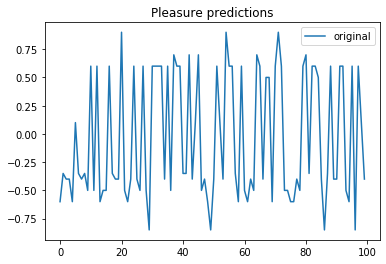

In [48]:
x_ax = range(100)
plt.plot(x_ax, test_y_p[0:100], label="original")

plt.title("Pleasure predictions")

plt.legend()
plt.show()

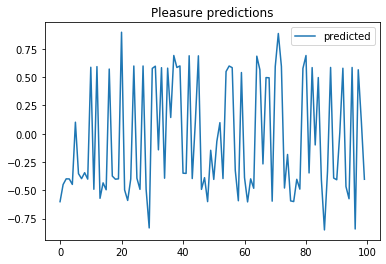

In [49]:
x_ax = range(100)
plt.plot(x_ax, pred_y_p[0:100], label="predicted")

plt.title("Pleasure predictions")

plt.legend()
plt.show()

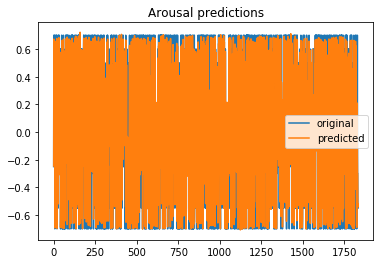

In [75]:
x_ax = range(len(test_y_a))
plt.plot(x_ax, test_y_a, label="original")
plt.plot(x_ax, pred_y_a, label="predicted")

plt.title("Arousal predictions")

plt.legend()
plt.show()

### Prediction Examples

In [ ]:
row=test_X.iloc[1]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)
y_d = model_d.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[1]))
print('Predicted: %s' % [y_p[0], y_a[0], y_d[0]])

In [ ]:
row=test_X.iloc[421]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)
y_d = model_d.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[421]))
print('Predicted: %s' % [y_p[0], y_a[0], y_d[0]])

In [ ]:
row=test_X.iloc[999]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)
y_d = model_d.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[999]))
print('Predicted: %s' % [y_p[0], y_a[0], y_d[0]])

## Save Models

In [ ]:
# save to JSON
model_p.save_model("models/l2p_dance_model_O.json")
model_a.save_model("models/l2a_dance_model_O.json")
model_d.save_model("models/l2d_dance_model_O.json")

## Load Models

In [155]:
model_p = xgb.XGBRegressor(verbosity=0)
model_p.load_model("models/l2p_dance_model.json")

model_a = xgb.XGBRegressor(verbosity=0)
model_a.load_model("models/l2a_dance_model.json")

model_d = xgb.XGBRegressor(verbosity=0)
model_d.load_model("models/l2d_dance_model.json")

### Graphs

In [156]:
pred_y_p = model_p.predict(test_X)
mse = mean_squared_error(test_y_p, pred_y_p)
mae = mean_absolute_error(test_y_p, pred_y_p)
print("Pleasure")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)


pred_y_a = model_a.predict(test_X)
mse = mean_squared_error(test_y_a, pred_y_a)
mae = mean_absolute_error(test_y_a, pred_y_a)
print("\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_d = model_d.predict(test_X)
mse = mean_squared_error(test_y_d, pred_y_d)
mae = mean_absolute_error(test_y_d, pred_y_d)
print("\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

Pleasure
MSE: 0.05
MAE: 0.08

Arousal
MSE: 0.03
MAE: 0.06

Arousal
MSE: 0.03
MAE: 0.06


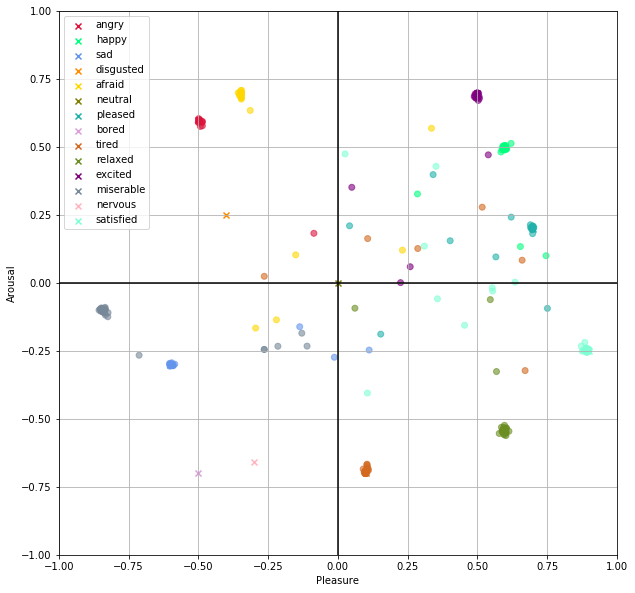

In [157]:
x = pred_y_p[0:300]
y = pred_y_a[0:300]

x_reference = [-0.5, 0.6, -0.6, 
               -0.4, 
               -0.35, 0.0, 0.7, -0.5, 0.1, 0.6, 0.5, -0.85, -0.3, 0.9]
y_reference = [0.6, 0.5, -0.3, 
               0.25, 
               0.7, 0.0, 0.2, -0.7, -0.7, -0.55, 0.7, -0.1, -0.66, -0.25]
colors_reference = ["crimson", "springgreen", "cornflowerblue", 
                    "darkorange", 
                    "gold", "olive", 
                    "lightseagreen", "plum", "chocolate", "olivedrab", "purple", "lightslategray",
                    "lightpink", "aquamarine"]

colors = []

color_map = {
    (-0.5, 0.6): "crimson",
    (0.6, 0.5): "springgreen",
    (-0.6, -0.3): "cornflowerblue",
    (-0.4, 0.25): "darkorange" ,
    (-0.35, 0.7): "gold",
    (0.0, 0.0): "olive", 
    (0.7, 0.2): "lightseagreen",
    (-0.5, -0.7): "plum",
    (0.1, -0.7): "chocolate",
    (0.6, -0.55): "olivedrab",
    (0.5, 0.7): "purple",
    (-0.85, -0.1): "lightslategray",
    (-0.3, -0.66): "lightpink",
    (0.9, -0.25): "aquamarine",
}

conv_dict = {
    (-0.5, 0.6): "angry",
    (0.6, 0.5): "happy",
    (-0.6, -0.3): "sad",
    (-0.4, 0.25): "disgusted" ,
    (-0.35, 0.7): "afraid",
    (0.0, 0.0): "neutral", 
    (0.7, 0.2): "pleased",
    (-0.5, -0.7): "bored",
    (0.1, -0.7): "tired",
    (0.6, -0.55): "relaxed",
    (0.5, 0.7): "excited",
    (-0.85, -0.1): "miserable",
    (-0.3, -0.66): "nervous",
    (0.9, -0.25): "satisfied",
    
}

for i in range(len(x)):
    point_coords = (test_y_p.iloc[i], test_y_a.iloc[i])
    
    colors.append(color_map[point_coords])

fig, ax = plt.subplots(figsize=(10,10))

for i in range(len(x_reference)):
    ax.scatter(x_reference[i], y_reference[i], c=colors_reference[i], label=conv_dict[(x_reference[i], y_reference[i])] , marker="x", linewidths=3)

ax.legend()

ax.scatter(x, y, c=colors, alpha=0.6)


line = mlines.Line2D([-1, 1], [0, 0], color='black')
line_2 = mlines.Line2D([0, 0], [-1, 1], color='black')
ax.add_line(line)
ax.add_line(line_2)


plt.ylim([-1,1])
plt.xlim([-1,1])


plt.xlabel('Pleasure')
plt.ylabel('Arousal')
plt.grid(True)

plt.show()



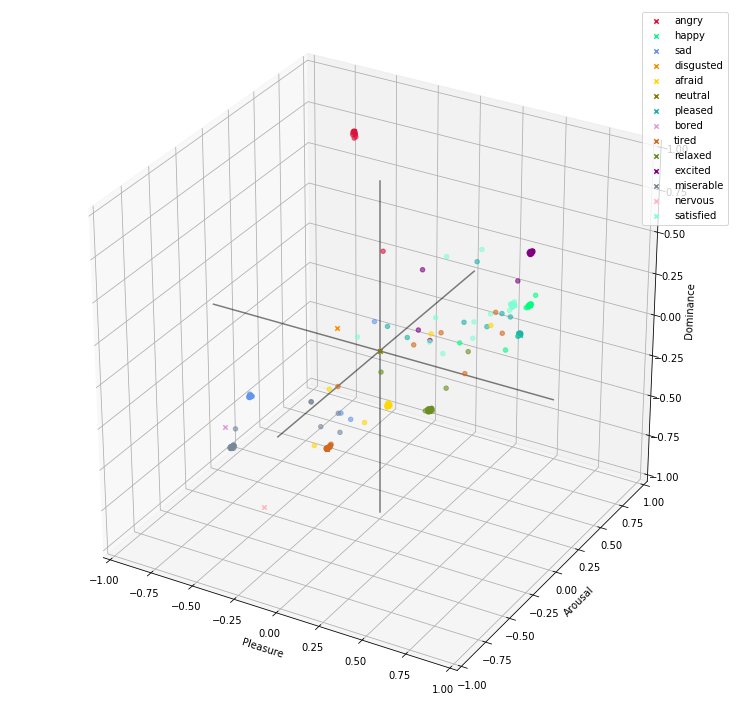

In [158]:
x = pred_y_p[0:300]
y = pred_y_a[0:300]
z = pred_y_d[0:300]

x_reference = [-0.5, 0.6, -0.6, 
               -0.4, 
               -0.35, 0.0, 0.7, -0.5, 0.1, 0.6, 0.5, -0.85, -0.3, 0.9]

y_reference = [0.6, 0.5, -0.3, 
               0.25, 
               0.7, 0.0, 0.2, -0.7, -0.7, -0.55, 0.7, -0.1, -0.66, -0.25]

z_reference = [ 0.9, 0.2, -0.3,
                -0.1,
                -0.8, 0.0, 0.2, -0.25, -0.2, 0.1, 0.4, -0.8, -0.7, 0.65]

colors_reference = ["crimson", "springgreen", "cornflowerblue", 
                    "darkorange", 
                    "gold", "olive", 
                    "lightseagreen", "plum", "chocolate", "olivedrab", "purple", "lightslategray",
                    "lightpink", "aquamarine"]

colors = []

color_map = {
    (-0.5, 0.6, 0.9): "crimson",
    (0.6, 0.5, 0.2): "springgreen",
    (-0.6, -0.3, -0.3): "cornflowerblue",
    (-0.4, 0.25, -0.1): "darkorange" ,
    (-0.35, 0.7, -0.8): "gold",
    (0.0, 0.0, 0.0): "olive", 
    (0.7, 0.2, 0.2): "lightseagreen",
    (-0.5, -0.7, -0.25): "plum",
    (0.1, -0.7, -0.2): "chocolate",
    (0.6, -0.55, 0.1): "olivedrab",
    (0.5, 0.7, 0.4): "purple",
    (-0.85, -0.1, -0.8): "lightslategray",
    (-0.3, -0.66, -0.7): "lightpink",
    (0.9, -0.25, 0.65): "aquamarine",
}

conv_dict = {
    (-0.5, 0.6, 0.9): "angry",
    (0.6, 0.5, 0.2): "happy",
    (-0.6, -0.3, -0.3): "sad",
    (-0.4, 0.25, -0.1): "disgusted" ,
    (-0.35, 0.7, -0.8): "afraid",
    (0.7, 0.2, 0.2): "pleased",
    (0.0, 0.0, 0.0): "neutral",
    (-0.5, -0.7, -0.25): "bored",
    (0.1, -0.7, -0.2): "tired",
    (0.6, -0.55, 0.1): "relaxed",
    (0.5, 0.7, 0.4): "excited",
    (-0.85, -0.1, -0.8): "miserable",
    (-0.3, -0.66, -0.7): "nervous",
    (0.9, -0.25, 0.65): "satisfied",   
}

for i in range(len(x)):
    point_coords = (test_y_p.iloc[i], test_y_a.iloc[i], test_y_d.iloc[i])
    
    colors.append(color_map[point_coords])

fig = plt.figure(figsize = (13, 13))
ax = plt.axes(projection ="3d")


for i in range(len(x_reference)):
    ax.scatter3D(x_reference[i], y_reference[i], z_reference[i], 
               c=colors_reference[i], 
               label=conv_dict[(x_reference[i], y_reference[i], z_reference[i])],
               marker="x", linewidths=3)

ax.legend()

ax.scatter(x, y, z, c=colors, alpha=0.6)


line = mplot3d.art3d.Line3D([-1, 1], [0, 0], [0,0], color='black', alpha=0.5)
line_2 = mplot3d.art3d.Line3D([0, 0], [-1, 1], [0,0], color='black', alpha = 0.5)
line_3 = mplot3d.art3d.Line3D([0, 0], [0, 0], [-1,1], color='black', alpha = 0.5)

ax.add_line(line)
ax.add_line(line_2)
ax.add_line(line_3)


ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])

ax.set_xlabel('Pleasure')
ax.set_ylabel('Arousal')
ax.set_zlabel('Dominance')
plt.grid(True)

plt.show()



# Hyperparameter Grid Search with XGBoost

In [68]:
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

import sklearn
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error


import xgboost as xgb

xgb.set_config(verbosity=2)

from sklearn.metrics import mean_squared_error

## Load Data

In [69]:
dataset = pd.read_csv('datasets/Fs_B_O_S_DANCE_WALK_KIN_0.5sec.csv')

### Split into Test and Train data

In [70]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

train_dataset = shuffle(train_dataset)
test_dataset = shuffle(test_dataset)

No Training Samples: 32147
No Test Samples: 8037


### Split Features from Targets

In [71]:
train_X = train_dataset.copy()
test_X = test_dataset.copy()

train_y = pd.concat([train_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A', "EMOTION_D"]], axis=1)
test_y = pd.concat([test_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A', "EMOTION_D"]], axis=1)

test_y_p = test_y.iloc[:,0]
train_y_p = train_y.iloc[:,0]

test_y_a = test_y.iloc[:,1]
train_y_a = train_y.iloc[:,1]

test_y_d = test_y.iloc[:,2]
train_y_d = train_y.iloc[:,2]

In [72]:
train_X.head()

,max_hand_distance,avg_l_hand_hip_distance,avg_r_hand_hip_distance,max_stride_length,avg_l_hand_chest_distance,avg_r_hand_chest_distance,avg_l_elbow_hip_distance,avg_r_elbow_hip_distance,avg_chest_pelvis_distance,avg_neck_chest_distance,...,l_hand_speed,r_hand_speed,l_foot_speed,r_foot_speed,neck_speed,l_hand_acceleration_magnitude,r_hand_acceleration_magnitude,l_foot_acceleration_magnitude,r_foot_acceleration_magnitude,neck_acceleration_magnitude
473,0.369055,-0.386076,-0.685156,1.800108,-0.045315,-0.483308,0.315798,-0.484612,0.151101,-0.438803,...,0.780005,2.313852,3.261770,0.707480,-0.377513,-0.014607,3.145238,2.782590,0.720094,0.038873
39836,-0.563194,0.552640,1.387571,0.713388,-1.825637,-0.456918,-1.146629,-0.189868,-0.573874,0.310763,...,0.884665,0.464675,0.630616,0.201774,1.177872,0.750169,0.910764,1.425443,1.028640,1.886095
8807,0.307478,-0.545323,-0.163070,1.617763,0.531301,0.787532,0.284766,0.538835,-0.147872,0.471214,...,1.469473,0.041754,-0.066149,1.185655,2.419173,0.427273,0.481374,0.613092,-0.339371,-0.399971
27256,1.138020,2.761723,-0.167372,0.330964,0.868076,-1.818014,1.899200,-1.487714,-0.658676,0.458409,...,0.228632,2.209758,0.339159,-0.328125,-0.492308,-0.223215,3.901250,0.230123,-0.036613,-0.045009
24408,-1.177554,-1.121025,-1.590578,-0.440755,-0.064481,-0.511963,-0.271752,-0.650360,-0.079211,0.027794,...,-1.091904,-1.077558,-0.943183,-0.969292,-0.919466,-0.784999,0.219230,-0.555439,-0.598699,-0.829344


In [73]:
train_y.head()

,EMOTION_P,EMOTION_A,EMOTION_D
473,0.50,0.7,0.4
39836,-0.60,-0.3,-0.3
8807,0.60,0.5,0.2
27256,-0.85,-0.1,-0.8
24408,-0.50,0.6,0.9


In [74]:
train_X.describe().transpose()[['mean', 'std']]

,mean,std
max_hand_distance,0.000457,0.999090
avg_l_hand_hip_distance,-0.001140,0.998326
avg_r_hand_hip_distance,-0.002224,0.997034
max_stride_length,-0.006667,0.996877
avg_l_hand_chest_distance,0.000445,0.997672
avg_r_hand_chest_distance,-0.003646,0.999507
avg_l_elbow_hip_distance,0.002430,0.996035
avg_r_elbow_hip_distance,-0.002056,0.997342
avg_chest_pelvis_distance,-0.000996,0.996905
avg_neck_chest_distance,0.002598,0.996785


## RandomSearchCV

In [75]:
# A parameter grid for XGBoost
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
params = {
        'eta': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 5, 11, 21],
        'max_depth': [3, 6, 10, 15],
        'gamma': [0, 0.001, 0.01],
        'subsample': [0.75, 1],
        'colsample_bytree': [0.75, 1],
        'lambda': [1, 1.25],
        'alpha': [0.0, 0.25]
        }

n_iter = 150

In [76]:
model_p = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

model_a = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

model_d = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

In [ ]:
# Pleasure
# run randomized search
kfold = KFold(n_splits=5, shuffle=True)

random_search_p = RandomizedSearchCV(model_p, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_p.fit(train_X, train_y_p)


print("GridSearchCV took %.2f seconds"
      " parameter settings." % ((time.time() - start)))

In [ ]:
# Arousal
kfold = KFold(n_splits=5, shuffle=True)

random_search_a = RandomizedSearchCV(model_a, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_a.fit(train_X, train_y_a)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

In [ ]:
# Dominance
kfold = KFold(n_splits=5, shuffle=True)

random_search_d = RandomizedSearchCV(model_d, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_d.fit(train_X, train_y_d)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

### Results

In [ ]:
best_regressor_p = random_search_p.best_estimator_

print(best_regressor_p.get_params())

In [ ]:
best_regressor_a = random_search_a.best_estimator_

print(best_regressor_a.get_params())

In [ ]:
best_regressor_d = random_search_d.best_estimator_

print(best_regressor_d.get_params())

In [ ]:
pred_y_p = best_regressor_p.predict(test_X)
mse = mean_squared_error(test_y_p, pred_y_p)
mae = mean_absolute_error(test_y_p, pred_y_p)
print("Pleasure")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_a = best_regressor_a.predict(test_X)
mse = mean_squared_error(test_y_a, pred_y_a)
mae = mean_absolute_error(test_y_a, pred_y_a)
print("\n\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_d = best_regressor_d.predict(test_X)
mse = mean_squared_error(test_y_d, pred_y_d)
mae = mean_absolute_error(test_y_d, pred_y_d)
print("\n\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

### Predictions

In [56]:
sample_no = 6
row=test_X.iloc[sample_no]

x = np.asarray([row])

y_p = best_regressor_p.predict(x)
y_a = best_regressor_a.predict(x)
y_d = best_regressor_d.predict(x)


print('Real: %s' % np.asarray(test_y.iloc[sample_no]))
print('Predicted: %s' % [y_p[0], y_a[0], y_d[0]])

Real: [0.6 0.5 0.2]
Predicted: [0.6024804, 0.48338908, 0.19020641]


## GridSearchCV

In [128]:
# A parameter grid for XGBoost
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
params = {
        'eta': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 5, 11, 21],
        'max_depth': [3, 6, 10, 15],
        'gamma': [0, 0.001, 0.01],
        'subsample': [0.75, 1],
        'colsample_bytree': [0.75, 1],
        'lambda': [1, 1.25],
        'alpha': [0.0, 0.25]
        }
#params = {
#        'n_estimators': [1000, 2000],
#        'min_child_weight': [10, 25],
#        'gamma': [0, 0.005, 0.01],
#        'learning_rate': [0.01, 0.07, 0.1],
#        'max_depth': [10, 20],
#        'lambda': [1, 1.25],
#        'alpha': [0.0, 0.25]
#        }

In [129]:
model_p = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

model_a = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

model_d = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

In [130]:
# Pleasure
# run randomized search
kfold = KFold(n_splits=5, shuffle=True)

random_search_p = GridSearchCV(model_p, param_grid=params,
                               cv=kfold, scoring='neg_mean_squared_error')

start = time.time()
random_search_p.fit(train_X, train_y_p)


print("GridSearchCV took %.2f seconds"
      " parameter settings." % ((time.time() - start)))

GridSearchCV took 34187.72 seconds parameter settings.


In [131]:
# Arousal
kfold = KFold(n_splits=5, shuffle=True)

random_search_a = GridSearchCV(model_a, param_grid=params,
                               cv=kfold, scoring='neg_mean_squared_error')

start = time.time()
random_search_a.fit(train_X, train_y_a)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

RandomizedSearchCV took 33562.72 seconds for 100 candidates parameter settings.


In [ ]:
# Dominance
kfold = KFold(n_splits=5, shuffle=True)

random_search_d = GridSearchCV(model_d, param_grid=params,
                               cv=kfold, scoring='neg_mean_squared_error')

start = time.time()
random_search_d.fit(train_X, train_y_d)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

### Results

In [378]:
best_regressor_p = random_search_p.best_estimator_

print(best_regressor_p.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 20, 'min_child_weight': 25, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1000, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1.25, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'alpha': 0.0, 'lambda': 1.25}


In [379]:
best_regressor_a = random_search_a.best_estimator_

print(best_regressor_a.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 20, 'min_child_weight': 25, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1000, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1.25, 'scale_pos_weight': 1, 'subsample': 1, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'alpha': 0.0, 'lambda': 1.25}


In [ ]:
best_regressor_d = random_search_d.best_estimator_

print(best_regressor_d.get_params())

In [380]:
pred_y_p = best_regressor_p.predict(test_X)
mse = mean_squared_error(test_y_p, pred_y_p)
mae = mean_absolute_error(test_y_p, pred_y_p)
print("Pleasure")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_a = best_regressor_a.predict(test_X)
mse = mean_squared_error(test_y_a, pred_y_a)
mae = mean_absolute_error(test_y_a, pred_y_a)
print("\n\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_d = best_regressor_d.predict(test_X)
mse = mean_squared_error(test_y_d, pred_y_d)
mae = mean_absolute_error(test_y_d, pred_y_d)
print("\n\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

Pleasure
MSE: 0.13
MAE: 0.25


Arousal
MSE: 0.40
MAE: 0.53


### Predictions

In [144]:
sample_no = 6
row=test_X.iloc[sample_no]

x = np.asarray([row])

y_p = best_regressor_p.predict(x)
y_a = best_regressor_a.predict(x)
y_d = best_regressor_d.predict(x)


print('Real: %s' % np.asarray(test_y.iloc[sample_no]))
print('Predicted: %s' % [y_p[0], y_a[0], y_d[0]])

Real: [-0.5 -0.7]
Predicted: [-0.542336, -0.690465]
